# Task summary

1. Load e-mails data to dataframe
2. Data analysis & preparation for classification
3. Classification

## 1. Loading data & preprocessing

In [1]:
import os, string
import pandas as pd
import numpy as np

In [2]:
directory="D:\Download\Trainingsmails_Anonym"
del_ = str.maketrans("","", string.punctuation) # for deleting punctuation
del_galki=str.maketrans("","", "<>") # for deleting <> in email addresses
NEWLINE="\n"

In [3]:
def to_base(tree):# makes dataframe from e-mail From, Subject & body w/o punctuation. only for .eml format, ignores errors in coding
    base=pd.DataFrame(columns=["Text", "Label"])
    for address, _, file in tree:
        for ff in file: 
            if not ff.endswith(".eml"):
                continue
            path = os.path.join(address,ff)
            with open(path, "r", errors='ignore', encoding="utf-8") as f:
                pased_header, lines=False, []
                for line in f:
                    if line.startswith("From:"):
                        line=line.replace("From: ", "").lower().translate(del_galki).replace("\n", "")
                        lines.append(line)
                    if line.startswith("Subject:"):
                        line=line.replace("Subject: ", "").lower().translate(del_).replace("\n", "").translate(del_galki) 
                        lines.append(line)
                    if pased_header:
                        line=line.lower().translate(del_).replace("\n", "").translate(del_galki)
                        lines.append(line)
                    elif line==NEWLINE:
                        pased_header=True
            content=NEWLINE.join(lines)            
            label=address.split("\\")[-1]
            row=pd.DataFrame({"Text":[content], "Label": [label]})
            base=base.append(row, ignore_index=True)
    return base

In [4]:
def to_base(tree): # makes dataframe with features w/o <> and punctuation. only for .eml format, ignores errors in coding
    base=pd.DataFrame(columns=["Text", "Label"])
    for address, _, file in tree: 
        for ff in file: 
            if not ff.endswith(".eml"):
                continue
            path = os.path.join(address,ff)
            with open(path, "r", errors='ignore', encoding="utf8") as f:
                text=[]
                for line in f:
                    if line.startswith("From:"):
                        line=line.replace("From: ", "").lower().translate(del_galki).replace("\n", "") 
                        lines=line +" "
                    if line.startswith("Subject:"):
                        line=line.replace("Subject: ", "").lower().translate(del_).replace("\n", "").translate(del_galki)  
                        lines=lines + line
                        text.append(lines)            
            label=address.split("\\")[-1]
            row=pd.DataFrame({"Text":text, "Label": label})
            base=base.append(row, ignore_index=True)
    return base

In [5]:
tree=os.walk(directory)
base=to_base(tree)
base.head()

,Text,Label
0,amazon.de promotion5@amazon.de hund hündin hos...,Amazon - diverse
1,amazon.de promotion5@amazon.de milestone baby ...,Amazon - diverse
2,amazon.de promotion5@amazon.de amazonde empfie...,Amazon - diverse
3,amazon.de promotion5@amazon.de amazonde empfie...,Amazon - diverse
4,amazon.de promotion5@amazon.de amazonde empfie...,Amazon - diverse


### Questions: 

- other common approaches to deal with text? Process punctuation, numbers, special symbols like <>, etc?

## 2. Data analysis & preparation for classification

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from matplotlib import pyplot as plt

In [7]:
y=base["Label"]
X=base["Text"]

In [8]:
# coding labels
feature_codes=zip( [i for i in range(0,16)], y.unique())
feature_codes={j: i for i,j in feature_codes} #dictionary folder: number
y=list(map(lambda i: feature_codes[i],y))


<Container object of 16 artists>

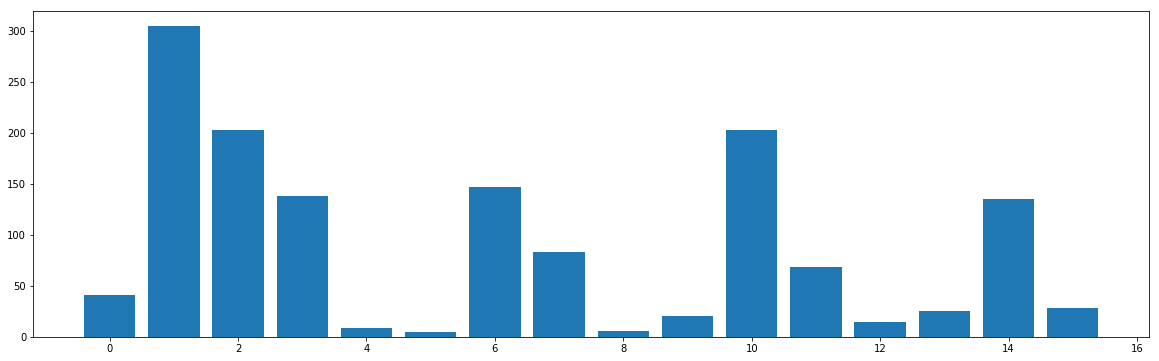

In [9]:
#highly imbalanced data set,gonna use oversampling later
plt.figure(figsize=(20,6))
plt.bar(Counter(y).keys(), Counter(y).values())


In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, cross_val_score, train_test_split
from sklearn import metrics

In [11]:
# fix warnings as f1 score is ill-defines for small classes 
import warnings
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

In [14]:
# looking for optimal words frequency to form a dictionary( define rare and buzz-words). I used all the base. Is it correct?

f1_scorer=metrics.make_scorer(metrics.f1_score, average="weighted" )
result=pd.DataFrame(columns=["max", "min", "cv_f1_score"])
max_df= [ 550, 600, 650, 700]
min_df= [ 5, 10]
for i in max_df:
    for j in min_df:
        vectorizer = CountVectorizer(max_df=i, min_df=j)
        vectorizer.fit(X)
        clf= LogisticRegression()
        clf.fit(vectorizer.transform(X), y)
        cvs=cross_val_score(clf, vectorizer.transform(X), y, 
                            cv=list(StratifiedShuffleSplit(test_size=0.3).split(X,y)), 
                            scoring=f1_scorer,
                           n_jobs=-1)
        row=pd.DataFrame([[i, j, cvs.mean()]],columns=["max", "min", "cv_f1_score"] )
        result=result.append(row, ignore_index=True)
result=result.sort_values("cv_f1_score", ascending=False).reset_index(drop=True)
result

,max,min,cv_f1_score
0,600,5,0.885299
1,550,5,0.881567
2,700,5,0.873767
3,650,5,0.872346
4,650,10,0.850444
5,600,10,0.850172
6,700,10,0.848012
7,550,10,0.843210


In [69]:
#I continue with 10<words frequency <650 and check if n_gram improves result. Seems like not really
result1=pd.DataFrame(columns=[ "ngram", "cv_f1_score"])
ngram= [ (1,2), (1,3)]
for i in ngram:
    vectorizer = CountVectorizer(max_df=650, min_df=10, ngram_range=i)
    vectorizer.fit(X)
    clf= LogisticRegression()
    clf.fit(vectorizer.transform(X), y)
    cvs=cross_val_score(clf, vectorizer.transform(X), y, 
                            cv=list(StratifiedShuffleSplit(test_size=0.3).split(X,y)), 
                            scoring=f1_scorer,
                           n_jobs=-1)
    row=pd.DataFrame([[i, cvs.mean()]],columns=[ "ngram", "cv_f1_score"] )
    result1=result1.append(row, ignore_index=True)
result1=result1.sort_values("cv_f1_score", ascending=False).reset_index(drop=True)
result1

,ngram,cv_f1_score
0,"(1, 2)",0.862646
1,"(1, 3)",0.845159


In [15]:
# transform text features to a matrix of tokened counts with 10<words frequency <650
vectorizer=CountVectorizer(max_df=650, min_df=10)
vectorizer.fit(X)
X_vect=vectorizer.transform(X)

In [16]:
# oversample process 
from imblearn.over_sampling import RandomOverSampler
ros=RandomOverSampler()
X_res, y_res = ros.fit_sample(X_vect,y)

In [17]:
Counter(y_res).items()

dict_items([(0, 305), (1, 305), (2, 305), (3, 305), (4, 305), (5, 305), (6, 305), (7, 305), (8, 305), (9, 305), (10, 305), (11, 305), (12, 305), (13, 305), (14, 305), (15, 305)])

In [18]:
# prepate train & test samples for resampled data
X_train, X_test, y_train, y_test=train_test_split(X_res, y_res, 
                                                  test_size=0.2, 
                                                  shuffle=True)

In [19]:
#  train & test samples for initial data w/o resampling
X_train_, X_test_, y_train_, y_test_=train_test_split(X_vect, y, 
                                                  test_size=0.2, 
                                                  shuffle=True)

### Questions

- other ways to create dictionary?
- common approach to text oversampling?

## 3. Classification

In [13]:
from sklearn.linear_model import LogisticRegression

In [22]:
scorer=metrics.make_scorer(metrics.f1_score, average="weighted")
clf=LogisticRegression(multi_class="multinomial", solver="lbfgs")
cvs=cross_val_score(clf, X_train, y_train, cv=5, scoring=scorer, n_jobs=-1 )

In [23]:
# high result on cross validation
cvs.mean()

0.9394639369873474

In [25]:
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [26]:
# the same result on test sample
print(metrics.classification_report(clf.predict(X_test_), y_test_))

             precision    recall  f1-score   support

          0       1.00      0.86      0.92         7
          1       0.96      0.96      0.96        54
          2       0.87      0.89      0.88        44
          3       0.96      0.61      0.75        36
          4       1.00      1.00      1.00         4
          5       1.00      0.33      0.50         3
          6       0.97      1.00      0.99        33
          7       0.91      1.00      0.95        10
          8       0.00      0.00      0.00         3
          9       1.00      1.00      1.00         4
         10       0.56      0.93      0.69        27
         11       1.00      1.00      1.00        20
         12       1.00      1.00      1.00         4
         13       1.00      1.00      1.00         1
         14       1.00      1.00      1.00        23
         15       1.00      0.86      0.92        14

avg / total       0.91      0.89      0.89       287



In [25]:
# try to improve model with grid search 
from sklearn.model_selection import GridSearchCV

In [26]:
params={"C": [0.5, 1, 2],
        "solver": ["lbfgs", "newton-cg", "liblinear", "sag"]
    
}
grid=GridSearchCV(LogisticRegression(), param_grid=params, cv=5, scoring=scorer, n_jobs=-1, return_train_score=False)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.5, 1, 2], 'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring=make_scorer(f1_score, average=weighted), verbose=0)

In [27]:
grid.best_params_

{'C': 2, 'solver': 'liblinear'}

In [28]:
grid.best_score_

0.9290129844121229

In [29]:
print(metrics.classification_report(grid.best_estimator_.predict(X_test_), y_test_))

             precision    recall  f1-score   support

          0       1.00      0.67      0.80         9
          1       0.88      0.98      0.93        52
          2       0.95      0.93      0.94        40
          3       0.93      0.74      0.82        34
          4       1.00      1.00      1.00         3
          5       0.00      0.00      0.00         6
          6       0.90      1.00      0.95        26
          7       0.89      0.85      0.87        20
          8       1.00      1.00      1.00         3
          9       1.00      1.00      1.00         2
         10       0.67      0.94      0.78        31
         11       1.00      1.00      1.00        15
         12       1.00      1.00      1.00         4
         13       1.00      1.00      1.00         3
         14       1.00      1.00      1.00        30
         15       1.00      0.67      0.80         9

avg / total       0.89      0.90      0.89       287



In [139]:
# looks like not a big improvement, thus stay with the last variant - Logistic Regression solver lfbgs, c=1.
#Test sample f1score 0.99, cross_val score 0.991
grid.cv_results_

{'mean_fit_time': array([17.7158,  9.4579,  9.5083, 22.0255, 21.7058, 10.5524,  8.4683,
        23.2319,  4.355 , 12.7491, 10.3836, 22.0559]),
 'mean_score_time': array([0.0052, 0.0056, 0.0054, 0.0058, 0.0054, 0.0058, 0.0054, 0.007 ,
        0.0058, 0.0092, 0.0056, 0.0052]),
 'mean_test_score': array([0.9907, 0.9907, 0.9905, 0.9766, 0.991 , 0.991 , 0.9907, 0.9763,
        0.991 , 0.991 , 0.991 , 0.9763]),
 'param_C': masked_array(data=[0.5, 0.5, 0.5, 0.5, 1, 1, 1, 1, 2, 2, 2, 2],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_solver': masked_array(data=['lbfgs', 'newton-cg', 'liblinear', 'sag', 'lbfgs',
                    'newton-cg', 'liblinear', 'sag', 'lbfgs', 'newton-cg',
                    'liblinear', 'sag'],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fi

### Questions:

- other algorithms? I tried MultinomialNB, result is worse
- how to tune LogisticRegression? Check if results improvement are statistically significant?
- rationale for using other scoring functions?
- how to increase precision in classification_report?

In [31]:
from sklearn.metrics import confusion_matrix
import itertools

In [32]:
cm=confusion_matrix(clf.predict(X_test_), y_test_)

In [33]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


np.set_printoptions(precision=2)



Confusion matrix, without normalization


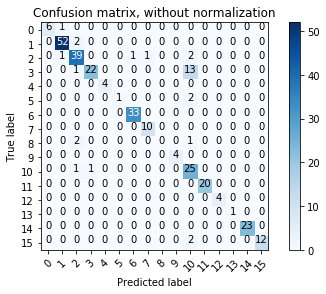

In [34]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=Counter(y).keys(),
                      title='Confusion matrix, without normalization')

Normalized confusion matrix


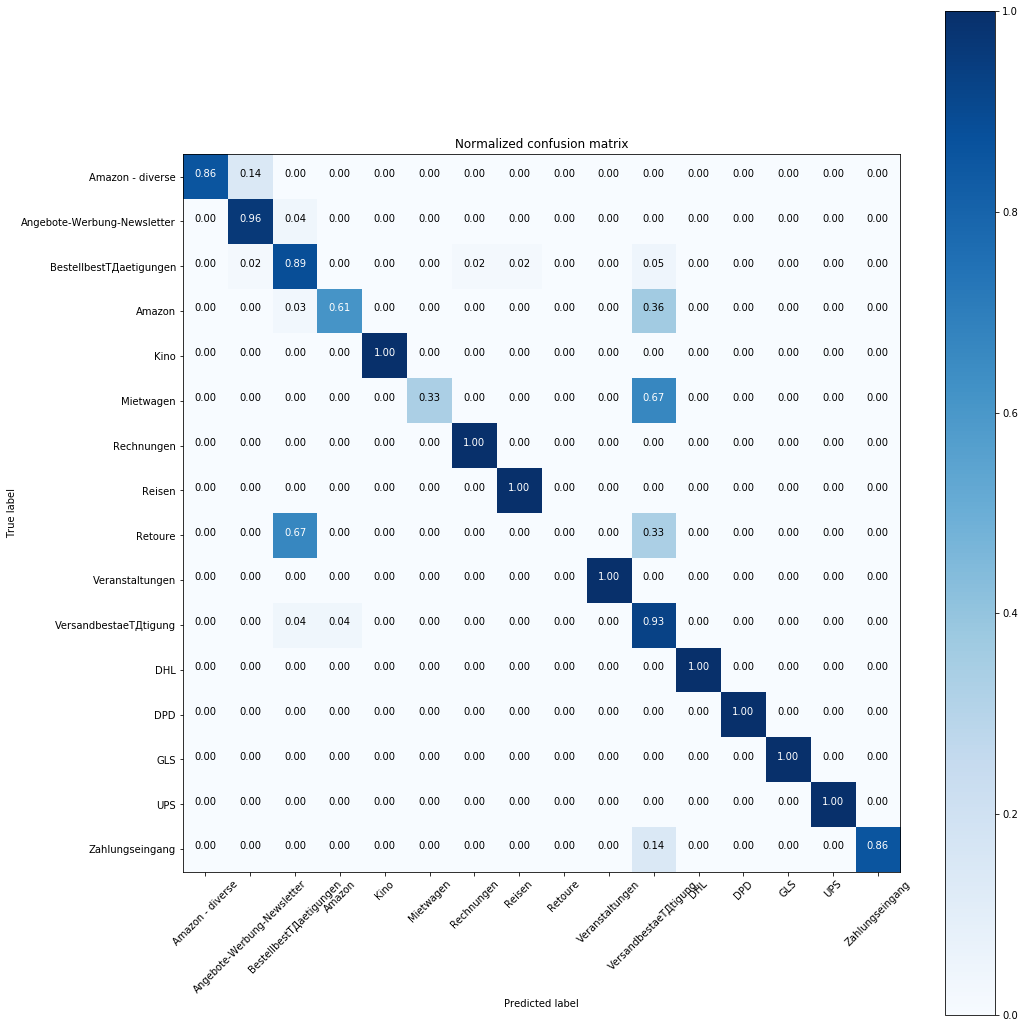

In [35]:
# Plot normalized confusion matrix
np.set_printoptions(precision=2)
plt.figure(figsize=(15,15))
plot_confusion_matrix(cm, classes=feature_codes.keys(), normalize=True,
                      title='Normalized confusion matrix')

plt.show()